### Preprocessing the Tabular Data of the 1 Million Soptify Songs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define the path to the data folder
data_path = 'spotify_data/spotify_data.csv'

# Load the Spotify data
spotify_data = pd.read_csv(data_path)
print(f"✓ Successfully loaded data from: {data_path}")
print(f"Dataset Shape: {spotify_data.shape[0]:,} rows × {spotify_data.shape[1]} columns")


✓ Successfully loaded data from: spotify_data/spotify_data.csv
Dataset Shape: 1,159,764 rows × 20 columns


In [3]:
spotify_data.head()

,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


Proportion of popularity 0: 13.66%


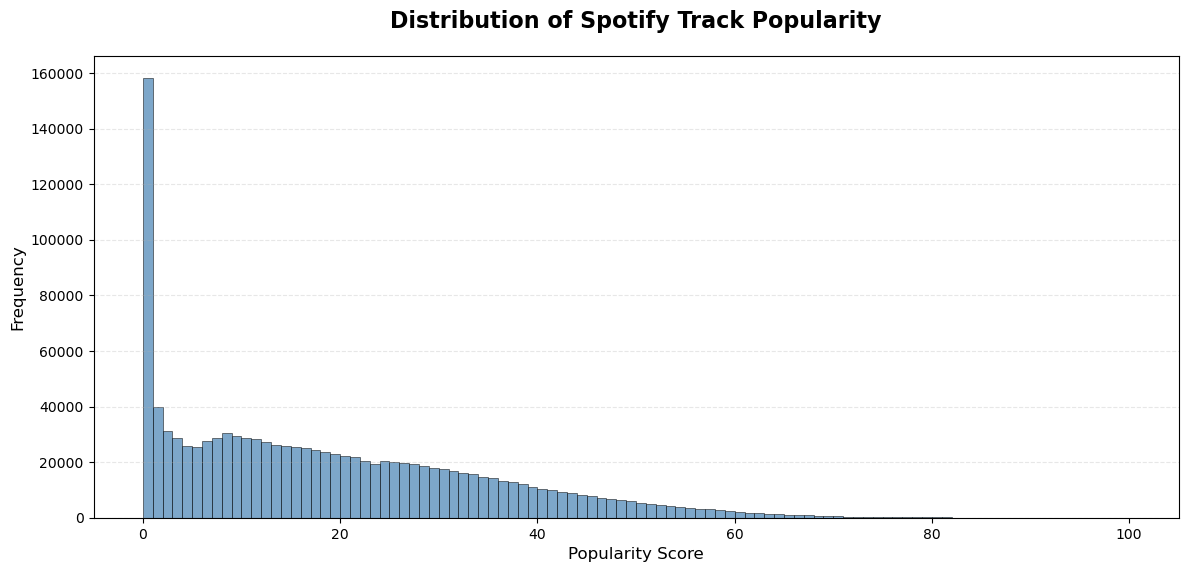

In [4]:
# See the distribution of the target variable, popularity

# Create figure with better size
plt.figure(figsize=(14, 6))

# Plot histogram with narrow bins
plt.hist(spotify_data['popularity'], bins=100, edgecolor='black', linewidth=0.5, alpha=0.7, color='steelblue')

plt.title('Distribution of Spotify Track Popularity', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Popularity Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')

zero_pop_ratio = (spotify_data['popularity'] == 0).mean()
print(f"Proportion of popularity 0: {zero_pop_ratio:.2%}")



We can see the data is skewed to the right, with 13% of the songs with popularity 0. We will define these 0 pupolarity songs as "flop", as well as the bottom 20% of the remaining songs. The top 0.5% of the songs are defines as "hit" which is where a song wants to be. Finally, all remaining songs are defined as "regular".

Note that this dataset is a snippet at 2023, so the recent songs in 2023 will naturally be more popular. To mitigate this, we take the top 0.5% of each year's release as the "pop" songs. Similarly, we take the bottom 205 songs (after getting rid of the zeros) as the flop


Classifying songs by year...



C:\Users\brian\AppData\Local\Temp\ipykernel_31324\4123086125.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spotify_data_classified = spotify_data.groupby('year', group_keys=False).apply(classify_popularity_by_year)



Overall Distribution of Song Categories (Year-Specific Thresholds):
Flop: 372,538 songs (32.12%)
Regular: 780,904 songs (67.33%)
Hit: 6,322 songs (0.55%)

Total: 1,159,764 songs

Sample: Distribution by Year (first 10 years)
pop    flop  hit  regular
year                     
2000  17828  229    25977
2001  16328  216    25807
2002  17100  227    24775
2003  15784  238    26346
2004  16630  240    26520
2005  16080  238    27462
2006  17090  260    28124
2007  16917  251    28833
2008  17124  259    30049
2009  16210  263    30396


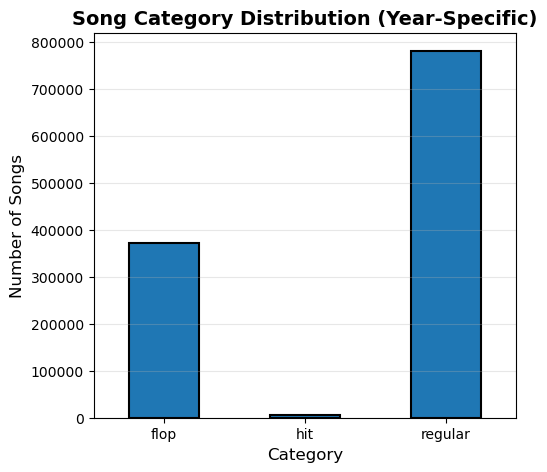

In [5]:
# Define the target variable based on popularity classification
# Apply classification BY YEAR - each year gets its own thresholds

def classify_popularity_by_year(year_df):
    """
    Classify songs within a single year into flop, regular, or hit
    based on that year's popularity distribution
    """
    # Calculate the proportion of zero popularity songs for this year
    zero_pop_ratio = (year_df['popularity'] == 0).mean()
    
    # Calculate the flop threshold (0 + bottom 20% of non-zero)
    flop_percentile = zero_pop_ratio + (1 - zero_pop_ratio) * 0.2
    
    # Calculate the hit threshold (top 0.5%)
    hit_percentile = 0.995
    
    # Get the actual popularity scores at these thresholds
    flop_threshold = year_df['popularity'].quantile(flop_percentile)
    hit_threshold = year_df['popularity'].quantile(hit_percentile)
    
    # Classify each song
    def classify(pop_score):
        if pop_score <= flop_threshold:
            return 'flop'
        elif pop_score >= hit_threshold:
            return 'hit'
        else:
            return 'regular'
    
    year_df['pop'] = year_df['popularity'].apply(classify)
    return year_df

# Apply classification year by year
print(f"{'='*60}")
print("Classifying songs by year...")
print(f"{'='*60}\n")

# Group by year and apply classification
spotify_data_classified = spotify_data.groupby('year', group_keys=False).apply(classify_popularity_by_year)

# Display overall distribution of categories
print(f"\n{'='*60}")
print("Overall Distribution of Song Categories (Year-Specific Thresholds):")
print(f"{'='*60}")
category_counts = spotify_data_classified['pop'].value_counts().sort_index()
category_pct = spotify_data_classified['pop'].value_counts(normalize=True).sort_index() * 100

for category in ['flop', 'regular', 'hit']:
    print(f"{category.capitalize()}: {category_counts[category]:,} songs ({category_pct[category]:.2f}%)")

print(f"\nTotal: {len(spotify_data_classified):,} songs")

# Show sample of distribution by year
print(f"\n{'='*60}")
print("Sample: Distribution by Year (first 10 years)")
print(f"{'='*60}")
year_distribution = spotify_data_classified.groupby(['year', 'pop']).size().unstack(fill_value=0)
print(year_distribution.head(10))

# Visualize the distribution
plt.figure(figsize=(12, 5))

# Bar plot
plt.subplot(1, 2, 1)
colors = '#1f77b4'
category_counts.plot(kind='bar', color=colors, edgecolor='black', linewidth=1.5)
plt.title('Song Category Distribution (Year-Specific)', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Songs', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.show()

# Update the main dataframe
spotify_data = spotify_data_classified.copy()

Another important indicator of a song's popularity if the "tier" of the artist, which we will leverage the dataset artist_popularity to put the artists in tiers.

Notice this data only have artists' information until 2019, which we will classify the artists that has their debut after 2019 as U, an unknown class

### Introduce artist_tier

In [6]:
# Feature engineering: artist tier
# Load the artist popularity data
data_path = 'artist_popularity/artists.csv'

# Load the Spotify data
artist_data = pd.read_csv(data_path)

C:\Users\brian\AppData\Local\Temp\ipykernel_31324\984839908.py:6: DtypeWarning: Columns (2,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  artist_data = pd.read_csv(data_path)


In [7]:
# Create artist tiers based on listeners_lastfm percentile ranks

# Step 1: Calculate percentile rank (handles duplicates properly)
# This gives each artist a percentile from 0 to 1
artist_data['listeners_percentile'] = artist_data['listeners_lastfm'].rank(pct=True, method='average')

# Convert to 0-1000 scale for easier interpretation
artist_data['listeners_quantile'] = (artist_data['listeners_percentile'] * 1000).round(0)

# Step 2: Create artist_tier based on percentile ranges
def assign_artist_tier(percentile):
    """
    Assign artist tier based on percentile (0-1 scale)
    S: Top 0.5% (percentile >= 0.995)
    A: Next 3.5% (percentile >= 0.96 and < 0.995)
    B: Next 10% (percentile >= 0.86 and < 0.96)
    C: Next 35% (percentile >= 0.51 and < 0.86)
    F: Bottom 51% (percentile < 0.51)
    """
    if pd.isna(percentile):
        return 'U'  # Unknown
    elif percentile >= 0.995:  # Top 0.5%
        return 'S'
    elif percentile >= 0.96:   # Top 4% (0.5% + 3.5%)
        return 'A'
    elif percentile >= 0.86:   # Top 14% (4% + 10%)
        return 'B'
    elif percentile >= 0.51:   # Top 49% (14% + 35%)
        return 'C'
    else:                      # Bottom 51%
        return 'F'

artist_data['artist_tier'] = artist_data['listeners_percentile'].apply(assign_artist_tier)

# Step 3: Select only artist_mb and artist_tier columns, keeping distinct values
# Assuming the artist identifier column is 'artist_mb' - adjust if different
artist_data_select = artist_data[['artist_mb', 'artist_tier']].drop_duplicates(subset=['artist_mb'])

# Step 4: Join with song_data (spotify_data) based on artist_name
# Left join to keep all songs
spotify_data = spotify_data.merge(
    artist_data_select, 
    left_on='artist_name', 
    right_on='artist_mb', 
    how='left'
)

# For artists not in the artist_data (debuts after 2019), assign 'U' for Unknown
spotify_data['artist_tier'].fillna('U', inplace=True)

# Step 5: Convert artist_tier to categorical with specific ordering
spotify_data['artist_tier'] = pd.Categorical(
    spotify_data['artist_tier'],
    categories=['S', 'A', 'B', 'C', 'F', 'U'],
    ordered=True
)

print(f"\n{'='*60}")
print(f"Artist Tier Distribution in Song Data")
print(f"{'='*60}")
print(f"Total songs: {len(spotify_data):,}")
print(f"\nTier breakdown:")
song_tier_counts = spotify_data['artist_tier'].value_counts().sort_index()
song_tier_pct = spotify_data['artist_tier'].value_counts(normalize=True).sort_index() * 100

for tier in ['S', 'A', 'B', 'C', 'F', 'U']:
    if tier in song_tier_counts.index:
        print(f"  {tier} tier: {song_tier_counts[tier]:,} songs ({song_tier_pct[tier]:.2f}%)")



Artist Tier Distribution in Song Data
Total songs: 1,159,764

Tier breakdown:
  S tier: 237,514 songs (20.48%)
  A tier: 340,119 songs (29.33%)
  B tier: 183,702 songs (15.84%)
  C tier: 93,527 songs (8.06%)
  F tier: 12,086 songs (1.04%)
  U tier: 292,816 songs (25.25%)


C:\Users\brian\AppData\Local\Temp\ipykernel_31324\3081366364.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  spotify_data['artist_tier'].fillna('U', inplace=True)


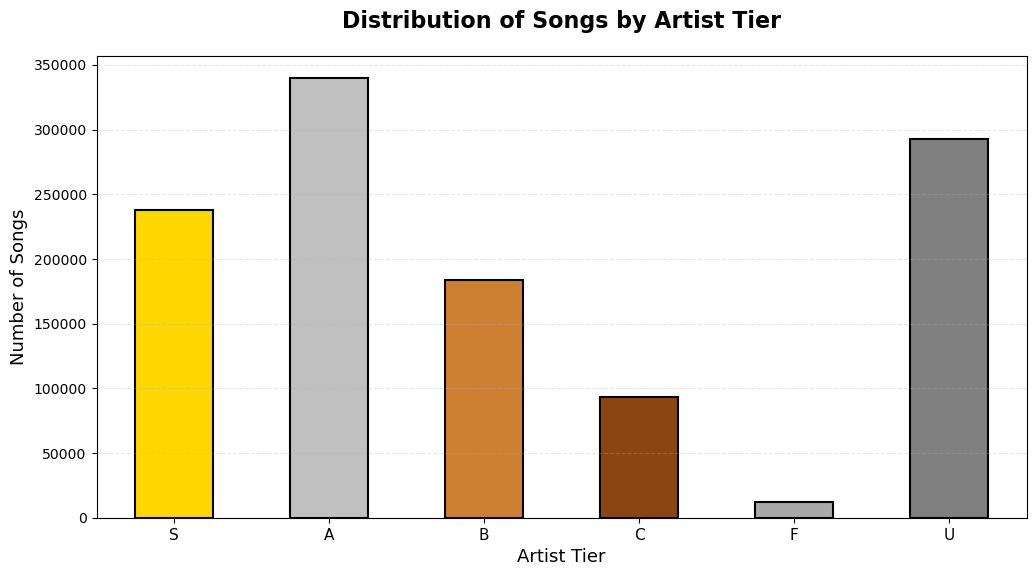

In [8]:

# Step 6: Create bar plot
plt.figure(figsize=(12, 6))
colors_tier = ['#FFD700', '#C0C0C0', '#CD7F32', '#8B4513', '#A9A9A9', '#808080']  
# Gold (S), Silver (A), Bronze (B), Brown (C), Dark gray (F), Gray (U)

ax = spotify_data['artist_tier'].value_counts().sort_index().plot(
    kind='bar', 
    color=colors_tier,
    edgecolor='black',
    linewidth=1.5
)

plt.title('Distribution of Songs by Artist Tier', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Artist Tier', fontsize=13)
plt.ylabel('Number of Songs', fontsize=13)
plt.xticks(rotation=0, fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.show()


### Select the useful variables and drop the used ones

In [70]:
# Select specific columns for the tabular dataset
spotify_data_tabular = spotify_data[[
    'track_id',
    'artist_name',
    'track_name',
    'popularity',
    'pop',
    'artist_tier',
    'year',
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'time_signature'
]].copy()

# Check for missing values
print(f"\n{'='*60}")
print("Missing Values:")
print(f"{'='*60}")
missing = spotify_data_tabular.isnull().sum()
if missing.sum() > 0:
    print("Missing values found:")
    print(missing[missing > 0])
    
    # Drop rows with missing values
    rows_before = len(spotify_data_tabular)
    spotify_data_tabular = spotify_data_tabular.dropna()
    rows_after = len(spotify_data_tabular)
    
    print(f"\n✓ Dropped {rows_before - rows_after:,} rows with missing values")
    print(f"Dataset shape after dropping missing values: {spotify_data_tabular.shape}")
else:
    print("✓ No missing values!")


Missing Values:
Missing values found:
artist_name    15
track_name      1
dtype: int64

✓ Dropped 16 rows with missing values
Dataset shape after dropping missing values: (1159748, 20)


### Introduce artist_perv_pop

We want to create a variable artist_perv_pop denoting the artist's historical performance (mean of popularity of their songs in the trainin set) to even better capture the artist's popularity in addition to their tier (which contains a lot of unknown artists).

since later on we will take songs releases up until 2021 as training set and after 2022 as test set, we will calculate the track record of an artist for songs up until 2021.

In [71]:
# Separate the dataset into pre 2021 and post 2022
spotify_data_tabular_pre_2021 = spotify_data_tabular[(spotify_data_tabular['year'] <= 2021)]
spotify_data_tabular_post_2022 = spotify_data_tabular[(spotify_data_tabular['year'] >= 2022)]



In [72]:
# Create the column artist_perv_pop based on pre2021 songs
spotify_data_tabular_pre_2021['artist_prev_pop'] = spotify_data_tabular_pre_2021.groupby('artist_name')['popularity'].transform('mean')
# Get the mapping form artist_name to artist_perv_pop
artist_pop = spotify_data_tabular_pre_2021.drop_duplicates("artist_name")
# Create mapping from artist_tier to artist_prev_pop
artist_tier_pop = (
    artist_pop
    .groupby("artist_tier")["artist_prev_pop"]
    .mean()
    .to_dict()
)



# For spotify_data_tabular_post_2022, left joinby artist name
spotify_data_tabular_post_2022 = spotify_data_tabular_post_2022.merge(artist_pop[['artist_name', 'artist_prev_pop']], on='artist_name', how='left')
# Impute those artist with NaN artist_prev_pop after matching artist names
spotify_data_tabular_post_2022['artist_prev_pop'] = np.where(
    spotify_data_tabular_post_2022['artist_prev_pop'].isna(),   # IF missing →
    spotify_data_tabular_post_2022['artist_tier'].map(artist_tier_pop),  # THEN impute
    spotify_data_tabular_post_2022['artist_prev_pop']           # ELSE keep original
)

C:\Users\brian\AppData\Local\Temp\ipykernel_31324\192546242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify_data_tabular_pre_2021['artist_prev_pop'] = spotify_data_tabular_pre_2021.groupby('artist_name')['popularity'].transform('mean')
C:\Users\brian\AppData\Local\Temp\ipykernel_31324\192546242.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("artist_tier")["artist_prev_pop"]


In [73]:
# Combine the two subsets
artist_prev_pop_full = pd.concat([
    spotify_data_tabular_pre_2021[['track_id', 'artist_prev_pop']],
    spotify_data_tabular_post_2022[['track_id', 'artist_prev_pop']]
], ignore_index=True)

# Merge this back to spotify_data_tabular to preserve the order

spotify_data_tabular = spotify_data_tabular.merge(
    artist_prev_pop_full,
    on='track_id',
    how='left'
)

# Select the useful columns
spotify_data_tabular = spotify_data_tabular[[
    'track_id',
    'artist_name',
    'track_name',
    'pop',
    'artist_tier',
    'artist_prev_pop',
    'year',
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'time_signature'
]].copy()


In [79]:
# Export the tabular dataset as csv
output_filename = 'spotify_data/spotify_data_tabular.csv'
spotify_data_tabular.to_csv(output_filename, index=False)

### Train/Test Split and Sampling

We need to be smart with our sampling. First, to mimic the real world scenario (use past model to predict new songs), we cannot perform a random train test split. In our case, we will train on the songs from 2000 all the way up to 2021, to predict the performance of songs released in 2022 and 2023.

Furthermore, we have a severe class imbalance. Thankfully, we have a large dataset and the minor class still has around 5000 observations. Since we're also facing a dataset size constraint due to collection of other modes, we will take an even sample, with 5500 songs each from each class, as our training set.

For our test set, we will take a subset (stratified by pop, the outcome variable) and try to oredict correctly on them, the size of the test set is aimed to be 5000 due to data collection contratins as well. This makes us end up with the train test split ratio of 75/25, which is also ideal to practice.

In [74]:
### Train/Test Split and Sampling

from sklearn.utils import resample

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print(f"{'='*70}")
print("TRAIN/TEST SPLIT - TIME-BASED + BALANCED SAMPLING")
print(f"{'='*70}\n")

# Step 1: Time-based split (Train: 2000-2021, Test: 2022-2023)
train_data = spotify_data_tabular[(spotify_data_tabular['year'] <= 2021)]
test_data = spotify_data_tabular[(spotify_data_tabular['year'] >= 2022)]

print("Step 1: Time-Based Split")
print(f"  Train period: 2000-2021 → {len(train_data):,} songs")
print(f"  Test period:  2022-2023 → {len(test_data):,} songs\n")

# Check class distribution in raw train data
print("Original Train Class Distribution:")
train_dist = train_data['pop'].value_counts().sort_index()
for cls in ['flop', 'regular', 'hit']:
    count = train_dist.get(cls, 0)
    pct = (count / len(train_data)) * 100 if len(train_data) > 0 else 0
    print(f"  {cls.capitalize():8s}: {count:6,} ({pct:5.2f}%)")



# Step 2: Balanced sampling from train data (5500 per class)
SAMPLES_PER_CLASS = 5500

train_balanced_list = []
print(f"\nStep 2: Balanced Sampling ({SAMPLES_PER_CLASS:,} per class)")

for cls in ['flop', 'regular', 'hit']:
    cls_data = train_data[train_data['pop'] == cls]
    
    if len(cls_data) >= SAMPLES_PER_CLASS:
        cls_sample = resample(cls_data, n_samples=SAMPLES_PER_CLASS, 
                             random_state=RANDOM_SEED, replace=False)
        print(f"  {cls.capitalize():8s}: sampled {len(cls_sample):,} from {len(cls_data):,} available")
    else:
        cls_sample = cls_data
        print(f"  ⚠ {cls.capitalize():8s}: only {len(cls_data):,} available (< {SAMPLES_PER_CLASS:,})")
    
    train_balanced_list.append(cls_sample)

train_balanced = pd.concat(train_balanced_list, ignore_index=True)
train_balanced = train_balanced.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

print(f"\nBalanced Training Set: {len(train_balanced):,} songs")
train_bal_dist = train_balanced['pop'].value_counts().sort_index()
for cls in ['flop', 'regular', 'hit']:
    count = train_bal_dist[cls]
    pct = (count / len(train_balanced)) * 100
    print(f"  {cls.capitalize():8s}: {count:6,} ({pct:5.2f}%)")

# Step 3: Stratified sampling from test data (5000 songs)
TEST_SIZE = 5000

print(f"\nStep 3: Stratified Test Sampling ({TEST_SIZE:,} songs)")
print("Original Test Class Distribution:")
test_dist = test_data['pop'].value_counts().sort_index()
for cls in ['flop', 'regular', 'hit']:
    count = test_dist.get(cls, 0)
    pct = (count / len(test_data)) * 100 if len(test_data) > 0 else 0
    print(f"  {cls.capitalize():8s}: {count:6,} ({pct:5.2f}%)")

# Stratified sampling
if len(test_data) >= TEST_SIZE:
    from sklearn.model_selection import train_test_split
    test_stratified, _ = train_test_split(test_data, train_size=TEST_SIZE, 
                                          stratify=test_data['pop'],
                                          random_state=RANDOM_SEED)
else:
    test_stratified = test_data
    print(f"  ⚠ Warning: Only {len(test_data):,} test samples available")

print(f"\nStratified Test Set: {len(test_stratified):,} songs")
test_strat_dist = test_stratified['pop'].value_counts().sort_index()
for cls in ['flop', 'regular', 'hit']:
    count = test_strat_dist.get(cls, 0)
    pct = (count / len(test_stratified)) * 100 if len(test_stratified) > 0 else 0
    print(f"  {cls.capitalize():8s}: {count:6,} ({pct:5.2f}%)")

# Summary
print(f"\n{'='*70}")
print("FINAL DATASET SUMMARY")
print(f"{'='*70}")
print(f"Training Set:   {len(train_balanced):6,} songs (balanced, 2000-2021)")
print(f"Test Set:       {len(test_stratified):6,} songs (stratified, 2022-2023)")
print(f"Total:          {len(train_balanced) + len(test_stratified):6,} songs")
print(f"{'='*70}\n")



TRAIN/TEST SPLIT - TIME-BASED + BALANCED SAMPLING

Step 1: Time-Based Split
  Train period: 2000-2021 → 1,067,407 songs
  Test period:  2022-2023 → 92,341 songs

Original Train Class Distribution:
  Flop    : 345,860 (32.40%)
  Regular : 715,750 (67.06%)
  Hit     :  5,797 ( 0.54%)

Step 2: Balanced Sampling (5,500 per class)
  Flop    : sampled 5,500 from 345,860 available
  Regular : sampled 5,500 from 715,750 available
  Hit     : sampled 5,500 from 5,797 available

Balanced Training Set: 16,500 songs
  Flop    :  5,500 (33.33%)
  Regular :  5,500 (33.33%)
  Hit     :  5,500 (33.33%)

Step 3: Stratified Test Sampling (5,000 songs)
Original Test Class Distribution:
  Flop    : 26,678 (28.89%)
  Regular : 65,138 (70.54%)
  Hit     :    525 ( 0.57%)

Stratified Test Set: 5,000 songs
  Flop    :  1,445 (28.90%)
  Regular :  3,527 (70.54%)
  Hit     :     28 ( 0.56%)

FINAL DATASET SUMMARY
Training Set:   16,500 songs (balanced, 2000-2021)
Test Set:        5,000 songs (stratified, 2022-2

In [77]:
# Export the train and test sets
train_balanced.to_csv('spotify_data/spotify_train_20k.csv', index=False)
test_stratified.to_csv('spotify_data/spotify_test_20k.csv', index=False)